# **`Detección De Diabetes`**

# **`Librerias`**

In [60]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, mean_squared_error, r2_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# **`Metadatos`**

In [61]:
# Clonamos el repositorio
!git clone https://github.com/LuigiHdez/Modelo_Clasificacion.git

#cargamos el dataset
data = pd.read_csv('/content/Modelo_Clasificacion/diabetes_prediction_dataset.csv')

# Cargar los metadatos desde el archivo JSON
with open('/content/Modelo_Clasificacion/diabetes-prediction-dataset-metadata.json') as f:
    metadatos_data = json.load(f)

# Iterar sobre los metadatos y mostrarlos
for clave, valor in metadatos_data.items():
    print(clave + ':', valor)

fatal: destination path 'Modelo_Clasificacion' already exists and is not an empty directory.
@context: {'@language': 'en', '@vocab': 'https://schema.org/', 'citeAs': 'cr:citeAs', 'column': 'cr:column', 'conformsTo': 'dct:conformsTo', 'cr': 'http://mlcommons.org/croissant/', 'data': {'@id': 'cr:data', '@type': '@json'}, 'dataBiases': 'cr:dataBiases', 'dataCollection': 'cr:dataCollection', 'dataType': {'@id': 'cr:dataType', '@type': '@vocab'}, 'dct': 'http://purl.org/dc/terms/', 'extract': 'cr:extract', 'field': 'cr:field', 'fileProperty': 'cr:fileProperty', 'fileObject': 'cr:fileObject', 'fileSet': 'cr:fileSet', 'format': 'cr:format', 'includes': 'cr:includes', 'isEnumeration': 'cr:isEnumeration', 'isLiveDataset': 'cr:isLiveDataset', 'jsonPath': 'cr:jsonPath', 'key': 'cr:key', 'md5': 'cr:md5', 'parentField': 'cr:parentField', 'path': 'cr:path', 'personalSensitiveInformation': 'cr:personalSensitiveInformation', 'recordSet': 'cr:recordSet', 'references': 'cr:references', 'regex': 'cr:rege

# **`Preprocesamiento`**

In [62]:
# Mostrar las primeras 5 filas
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [63]:
# Revisar la información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


## **`Codificacion De Variables Categóricas`**

### **`GENDER`**

In [64]:
# Obtener los valores unicos de la columna 'gender'
uVGender = data['gender'].unique()
print("Valores únicos de la columna 'gender': ", uVGender)

Valores únicos de la columna 'gender':  ['Female' 'Male' 'Other']


In [65]:
# Realizar la codificación one-hot
mapData = pd.get_dummies(data, columns=['gender'], dtype=int)

# Mostrar el DataFrame codificado
mapData.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other
0,80.0,0,1,never,25.19,6.6,140,0,1,0,0
1,54.0,0,0,No Info,27.32,6.6,80,0,1,0,0
2,28.0,0,0,never,27.32,5.7,158,0,0,1,0
3,36.0,0,0,current,23.45,5.0,155,0,1,0,0
4,76.0,1,1,current,20.14,4.8,155,0,0,1,0


### **`SMOKING HISTORY`**

In [66]:
uVSmoking = mapData['smoking_history'].unique()
print("Valores únicos de la columna 'smoking_history': ", uVSmoking)

Valores únicos de la columna 'smoking_history':  ['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [67]:
# Creamos un diccionario de mapeo
mapSmoking = {'No Info':0, 'never':1, 'ever':2, 'not current':3, 'former':4, 'current':5}

# Usamos el método replace para clasificar las categorías
mapData['smoking_history'] = mapData['smoking_history'].replace(mapSmoking)

# Mostramos las primeras filas del DataFrame mapData
mapData.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other
0,80.0,0,1,1,25.19,6.6,140,0,1,0,0
1,54.0,0,0,0,27.32,6.6,80,0,1,0,0
2,28.0,0,0,1,27.32,5.7,158,0,0,1,0
3,36.0,0,0,5,23.45,5.0,155,0,1,0,0
4,76.0,1,1,5,20.14,4.8,155,0,0,1,0


# **`Estadística`**

In [68]:
mapData.describe()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,1.462820,27.320767,5.527507,138.058060,0.085000,0.585520,0.414300,0.000180
std,22.516840,0.26315,0.194593,1.664135,6.636783,1.070672,40.708136,0.278883,0.492635,0.492603,0.013415
min,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000,1.000000,0.000000,0.000000
75%,60.000000,0.00000,0.000000,3.000000,29.580000,6.200000,159.000000,0.000000,1.000000,1.000000,0.000000
max,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000,1.000000,1.000000,1.000000


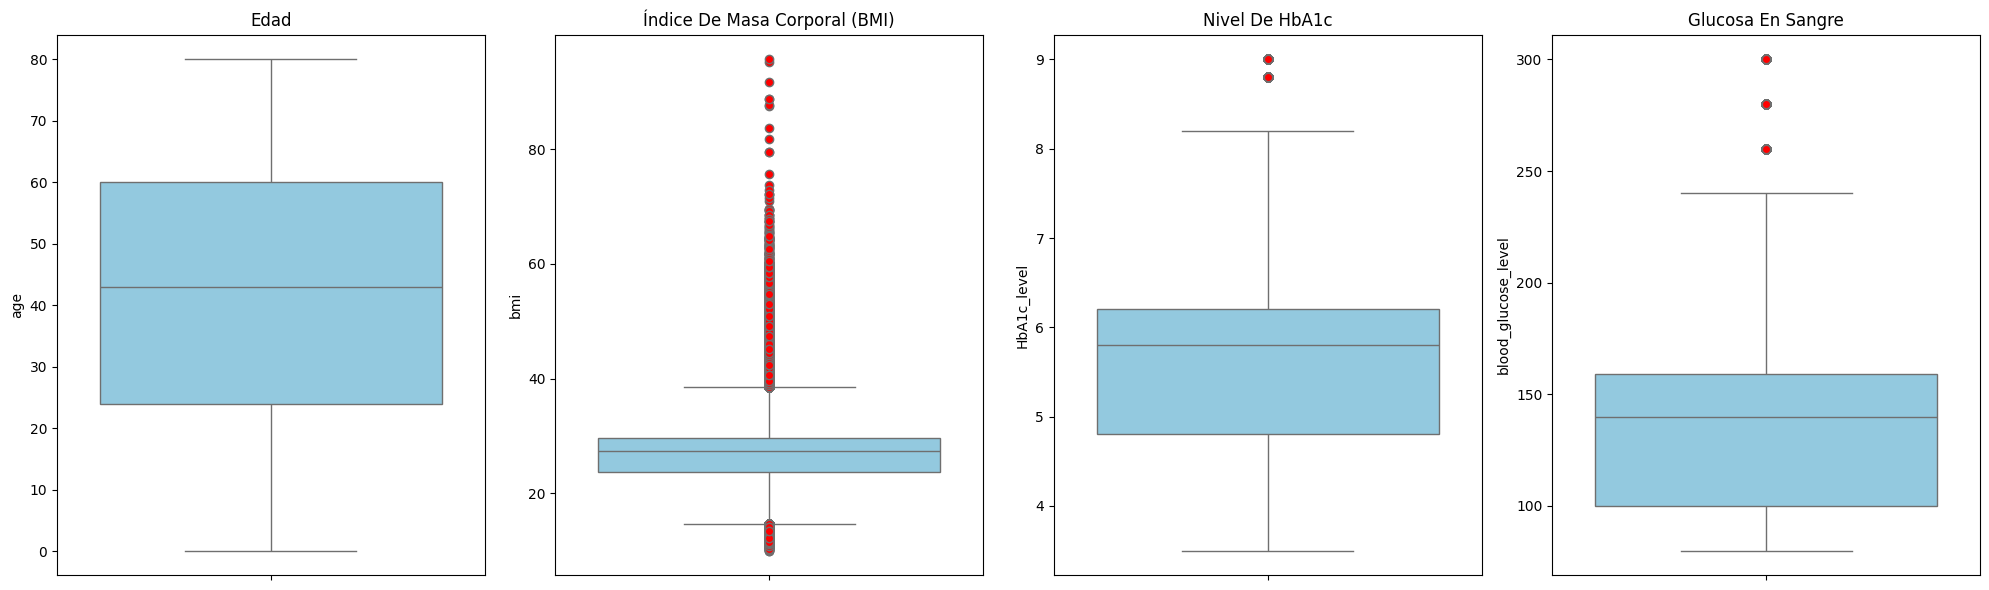

In [69]:
# Crear subplots para cada boxplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

# Boxplot para la columna 'age'
sns.boxplot(ax=axes[0], data=data['age'], color='skyblue', flierprops=dict(markerfacecolor='red', marker='o'))
axes[0].set_title('Edad')

# Boxplot para la columna 'bmi'
sns.boxplot(ax=axes[1], data=data['bmi'], color='skyblue', flierprops=dict(markerfacecolor='red', marker='o'))
axes[1].set_title('Índice De Masa Corporal (BMI)')

# Boxplot para la columna 'HbA1c_level'
sns.boxplot(ax=axes[2], data=data['HbA1c_level'], color='skyblue', flierprops=dict(markerfacecolor='red', marker='o'))
axes[2].set_title('Nivel De HbA1c')

# Boxplot para la columna 'blood_glucose_level'
sns.boxplot(ax=axes[3], data=data['blood_glucose_level'], color='skyblue', flierprops=dict(markerfacecolor='red', marker='o'))
axes[3].set_title('Glucosa En Sangre')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [70]:
print(pd.value_counts(mapData['hypertension'], sort = True), '\n')
print(pd.value_counts(mapData['heart_disease'], sort = True), '\n')
print(pd.value_counts(data['smoking_history'], sort = True), '\n')
print(pd.value_counts(data['gender'], sort = True), '\n')
print(pd.value_counts(mapData['diabetes'], sort = True))

hypertension
0    92515
1     7485
Name: count, dtype: int64 

heart_disease
0    96058
1     3942
Name: count, dtype: int64 

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64 

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64 

diabetes
0    91500
1     8500
Name: count, dtype: int64


In [71]:
# Datos
x_hypertension = ["No", "yes"]
y_hypertension = [92515, 7485]

x_heart_disease = ["No", "yes"]
y_heart_disease = [96058, 3942]

x_smoking_history = ['No Info', 'Never', 'Ever', 'Not Current', 'Former', 'Current']
y_smoking_history = [35816, 35095, 4004, 6447, 9352, 9286]

x__gender = ["Female", "Male", "Other"]
y_gender = [58552, 41430, 18]

x_diabetes = ["No", "yes"]
y_diabetes = [91500, 8500]

colores = ['cyan', 'salmon']

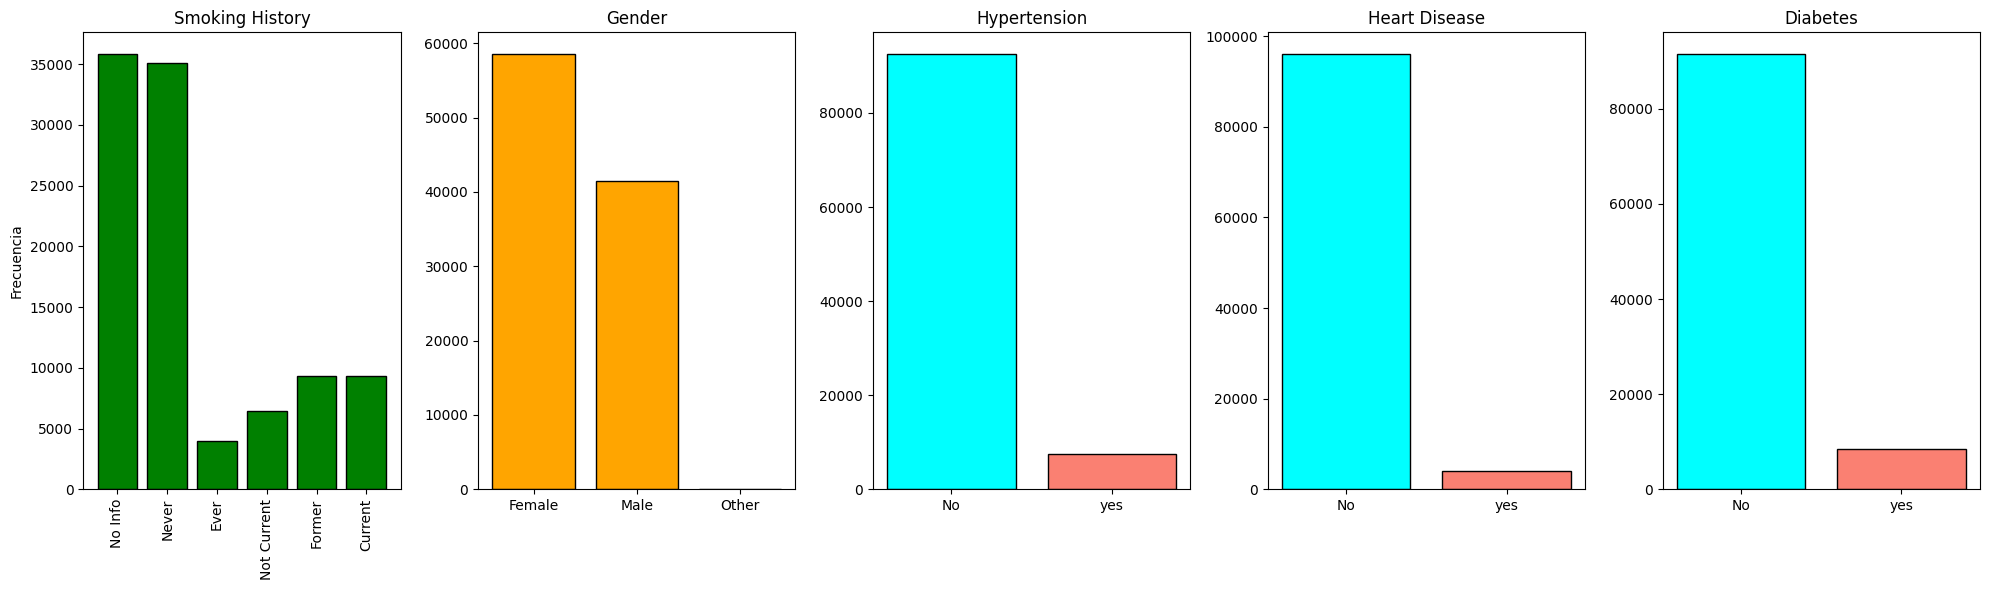

In [72]:
# Crear subplots para cada Gráfico de barras
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

# Gráfico de barras para la columna 'smoking_history'
axes[0].bar(x = x_smoking_history, height = y_smoking_history, color= "green", edgecolor='black')
axes[0].set_title('Smoking History')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticks(range(len(x_smoking_history)))
axes[0].set_xticklabels(x_smoking_history, rotation=90)

# Gráfico de barras para la columna 'gender'
axes[1].bar(x = x__gender, height = y_gender, color= "orange", edgecolor='black')
axes[1].set_title('Gender')

# Gráfico de barras para la columna 'hypertension'
axes[2].bar(x = x_hypertension, height = y_hypertension, color= colores, edgecolor='black')
axes[2].set_title('Hypertension')

# Gráfico de barras para la columna 'heart_disease'
axes[3].bar(x = x_heart_disease, height = y_heart_disease, color= colores, edgecolor='black')
axes[3].set_title('Heart Disease')

# Gráfico de barras para la columna 'diabetes'
axes[4].bar(x = x_diabetes, height = y_diabetes, color= colores, edgecolor='black')
axes[4].set_title('Diabetes')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

# **`Clasificación`**

# **`Decision Tree Classifier`**

## **`Primer Entrenamiento`**

In [73]:
#features = mapData sin la columna 'diabetes'
features_classifier = mapData.drop('diabetes', axis=1).columns

X_classifier = mapData[features_classifier]    # Features
y_classifier = mapData['diabetes']  # Target variable

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size=0.2, random_state=101) # 80% training and 20% test

### **`Criterio De Gini`**

In [74]:
clf_gini_classifier = DecisionTreeClassifier(criterion='gini', class_weight="balanced")
clf_gini_classifier = clf_gini_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_gini_train_classifier = clf_gini_classifier.predict(X_train_classifier)
y_pred_gini_test_classifier = clf_gini_classifier.predict(X_test_classifier)

### **`Train Gini`**



Accuracy: 0.99892
Recall: 1.0
Precision: 0.98757
F1-Score: 0.99375


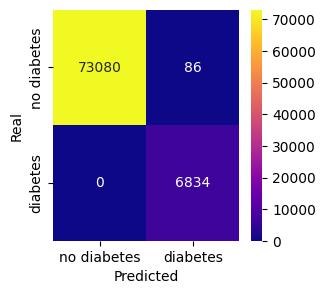

In [75]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_gini_train_classifier),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_gini_train_classifier),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_gini_train_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_gini_train_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_gini_train_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test Gini`**

Accuracy: 0.9531
Recall: 0.70948
Precision: 0.72249
F1-Score: 0.71593


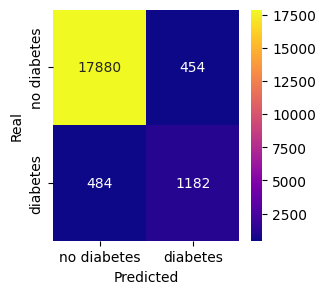

In [76]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_gini_test_classifier),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_gini_test_classifier),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_gini_test_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_gini_test_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_gini_test_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Importances Gini`**

In [77]:
importances_gini_classifier = pd.DataFrame({'feature':features_classifier,'importancia':np.round(clf_gini_classifier.feature_importances_,5)})
importances_gini_classifier.sort_values(by='importancia',ascending=False,inplace=True)
importances_gini_classifier.set_index('feature')

,importancia
feature,
HbA1c_level,0.41170
blood_glucose_level,0.30283
age,0.13265
bmi,0.10676
smoking_history,0.02404
hypertension,0.00770
gender_Female,0.00519
gender_Male,0.00511
heart_disease,0.00399


### **`Entropia`**

In [78]:
clf_entropy_classifier = DecisionTreeClassifier(criterion='entropy', class_weight="balanced")
clf_entropy_classifier = clf_entropy_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_entropy_train_classifier =clf_entropy_classifier.predict(X_train_classifier)
y_pred_entropy_test_classifier = clf_entropy_classifier.predict(X_test_classifier)

### **`Train Entropia`**

Accuracy: 0.99892
Recall: 1.0
Precision: 0.98757
F1-Score: 0.99375


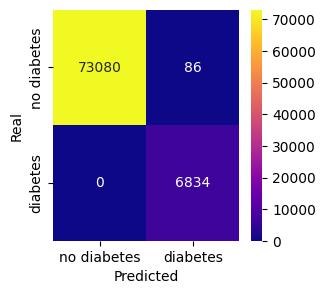

In [79]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_entropy_train_classifier),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_entropy_train_classifier),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_entropy_train_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_entropy_train_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_entropy_train_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test Entropia`**

Accuracy: 0.952
Recall: 0.71909
Precision: 0.70888
F1-Score: 0.71395


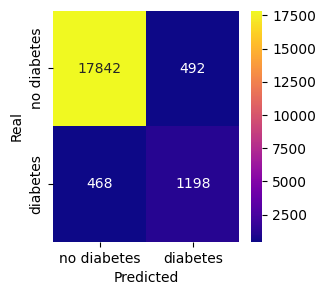

In [81]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_entropy_test_classifier),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_entropy_test_classifier),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_entropy_test_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_entropy_test_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_entropy_test_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Importances Entropia`**

In [82]:
importances_entropy_classifier = pd.DataFrame({'feature':features_classifier,'importancia':np.round(clf_entropy_classifier.feature_importances_,5)})
importances_entropy_classifier.sort_values(by='importancia',ascending=False,inplace=True)
importances_entropy_classifier.set_index('feature')

,importancia
feature,
HbA1c_level,0.42714
blood_glucose_level,0.29486
age,0.12432
bmi,0.10949
smoking_history,0.02444
hypertension,0.00674
gender_Male,0.00521
gender_Female,0.00442
heart_disease,0.00338


## **`Segundo Entrenamiento`**

In [83]:
features_classifier = features_classifier.drop('gender_Other')
X_classifier= mapData[features_classifier]    # Features
y_classifier = mapData['diabetes']  # Target variable

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size=0.2, random_state=101) # 80% training and 20% test

### **`Threshold`**

In [84]:
selector_threshold_classifier = VarianceThreshold(0.25)
scaler_classifier = MinMaxScaler()
clf_entropy_classifier = DecisionTreeClassifier(criterion='entropy', class_weight="balanced")

pl_threshold_classifier = Pipeline([('selector',selector_threshold_classifier),
               ('escalador',scaler_classifier),
               ('clasificador',clf_entropy_classifier)])


pl_threshold_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_pl_threshold_classifier_train = pl_threshold_classifier.predict(X_train_classifier)
y_pred_pl_threshold_classifier_test = pl_threshold_classifier.predict(X_test_classifier)

### **`Train Threshold`**

Accuracy: 0.99675
Recall: 1.0
Precision: 0.96335
F1-Score: 0.98133


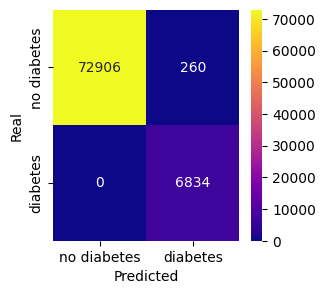

In [85]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_pl_threshold_classifier_train),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_pl_threshold_classifier_train),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_pl_threshold_classifier_train),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_pl_threshold_classifier_train), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_pl_threshold_classifier_train)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test Threshold`**

Accuracy: 0.94965
Recall: 0.71669
Precision: 0.69057
F1-Score: 0.70339


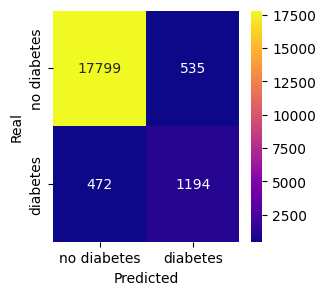

In [86]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_pl_threshold_classifier_test),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_pl_threshold_classifier_test),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_pl_threshold_classifier_test),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_pl_threshold_classifier_test), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_pl_threshold_classifier_test)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`K`**

In [87]:
selector_k_classifier = SelectKBest(k=5)

pl_k_classifier = Pipeline([('selector',selector_k_classifier),
               ('escalador',scaler_classifier),
               ('clasificador',clf_entropy_classifier)])

pl_k_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_pl_k_classifier_train = pl_k_classifier.predict(X_train_classifier)
y_pred_pl_k_classifier_test = pl_k_classifier.predict(X_test_classifier)

### **`Train K`**

Accuracy: 0.99302
Recall: 0.99956
Precision: 0.92486
F1-Score: 0.96076


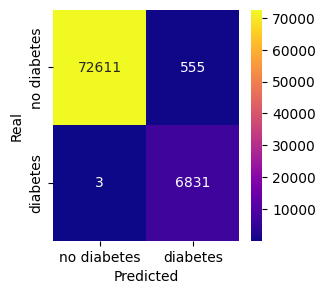

In [88]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_pl_k_classifier_train),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_pl_k_classifier_train),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_pl_k_classifier_train),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_pl_k_classifier_train), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_pl_k_classifier_train)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test K`**

Accuracy: 0.9475
Recall: 0.72269
Precision: 0.67188
F1-Score: 0.69636


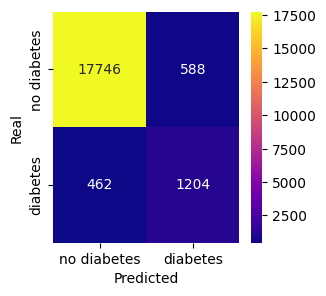

In [89]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_pl_k_classifier_test),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_pl_k_classifier_test),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_pl_k_classifier_test),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_pl_k_classifier_test), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_pl_k_classifier_test)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

## **`Busqueda de hiperparametros Threshold`**

In [90]:
param_grid_threshold_classifier = {
    "selector__threshold": [0, 0.1, 0.2, 0.5],
    "clasificador__criterion": ['gini', 'entropy', 'log_loss'],
    "clasificador__max_depth": [None, 125, 150, 175],
    "clasificador__min_samples_split": [2, 3, 4, 5, 10]
}


# Configurar la búsqueda de cuadrícula con validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instanciar GridSearchCV
search_threshold_classifier = GridSearchCV(pl_threshold_classifier, param_grid_threshold_classifier, cv=cv, n_jobs=-1, scoring=make_scorer(f1_score))

search_threshold_classifier.fit(X_train_classifier, y_train_classifier)
print("Best parameter (CV score=%0.3f):" % search_threshold_classifier.best_score_)
print(search_threshold_classifier.best_params_)

Best parameter (CV score=0.734):
{'clasificador__criterion': 'gini', 'clasificador__max_depth': 150, 'clasificador__min_samples_split': 2, 'selector__threshold': 0}


## **`Busqueda de hiperparametros K`**

In [95]:
param_grid_k_classifier = {
    "selector__k": [2, 3, 4, 5, 6],
    "clasificador__criterion": ['gini', 'entropy', 'log_loss'],
    "clasificador__max_depth": [None, 125, 150, 175],
    "clasificador__min_samples_split": [2, 3, 4, 5, 10]
}

# Instanciar GridSearchCV
search_k_classifier = GridSearchCV(pl_k_classifier, param_grid_k_classifier, cv=cv, n_jobs=-1, scoring=make_scorer(f1_score))
search_k_classifier.fit(X_train_classifier, y_train_classifier)

print("Best parameter (CV score=%0.3f):" % search_k_classifier.best_score_)
print(search_k_classifier.best_params_)

Best parameter (CV score=0.730):
{'clasificador__criterion': 'log_loss', 'clasificador__max_depth': 175, 'clasificador__min_samples_split': 2, 'selector__k': 6}


## **`Tercer Entrenamiento`**

### **`Threshold`**

In [92]:
selector_threshold_best_classifier = VarianceThreshold(0)

clf_threshold_best_classifier = DecisionTreeClassifier(criterion='gini', max_depth=150, min_samples_split=2, class_weight="balanced")


pl_threshold_best_classifier = Pipeline([('selector',selector_threshold_best_classifier),
               ('escalador',scaler_classifier),
               ('clasificador',clf_threshold_best_classifier)])


pl_threshold_best_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_pl_threshold_best_classifier_train = pl_threshold_best_classifier.predict(X_train_classifier)
y_pred_pl_threshold_best_classifier_test = pl_threshold_best_classifier.predict(X_test_classifier)

### **`Train Threshold`**

Accuracy: 0.99892
Recall: 1.0
Precision: 0.98757
F1-Score: 0.99375


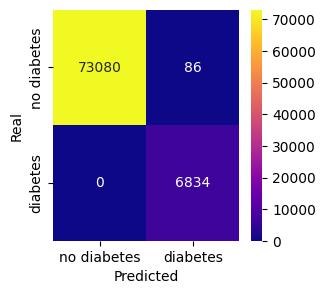

In [93]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_pl_threshold_best_classifier_train),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_pl_threshold_best_classifier_train),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_pl_threshold_best_classifier_train),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_pl_threshold_best_classifier_train), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_pl_threshold_best_classifier_train)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test Threshold`**

Accuracy: 0.9535
Recall: 0.70888
Precision: 0.72632
F1-Score: 0.7175


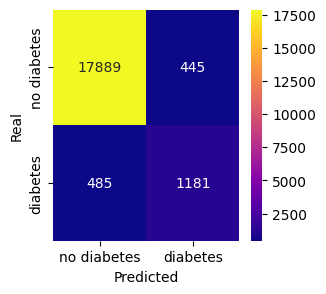

In [94]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_pl_threshold_best_classifier_test),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_pl_threshold_best_classifier_test),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_pl_threshold_best_classifier_test),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_pl_threshold_best_classifier_test), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_pl_threshold_best_classifier_test)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`K`**

In [96]:
selector_k_best_classifier = SelectKBest(k=6)

clf_k_best_classifier = DecisionTreeClassifier(criterion='log_loss', max_depth=175, min_samples_split=2, class_weight="balanced")

pl_k_best_classifier = Pipeline([('selector',selector_k_best_classifier),
               ('escalador',scaler_classifier),
               ('clasificador',clf_k_best_classifier)])

pl_k_best_classifier.fit(X_train_classifier,y_train_classifier)

y_pred_pl_k_best_classifier_train = pl_k_best_classifier.predict(X_train_classifier)
y_pred_pl_k_best_classifier_test = pl_k_best_classifier.predict(X_test_classifier)

### **`Train K`**

Accuracy: 0.99392
Recall: 0.99985
Precision: 0.93373
F1-Score: 0.96566


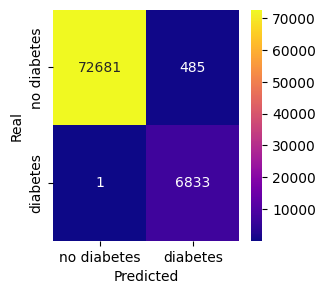

In [97]:
print(f"Accuracy: {round(accuracy_score(y_train_classifier,y_pred_pl_k_best_classifier_train),5)}")
print(f"Recall: {round(recall_score(y_train_classifier,y_pred_pl_k_best_classifier_train),5)}")
print(f"Precision: {round(precision_score(y_train_classifier,y_pred_pl_k_best_classifier_train),5)}")
print(f"F1-Score: {round(f1_score(y_train_classifier, y_pred_pl_k_best_classifier_train), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_classifier,y_pred_pl_k_best_classifier_train)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test K`**

Accuracy: 0.9492
Recall: 0.72929
Precision: 0.68258
F1-Score: 0.70517


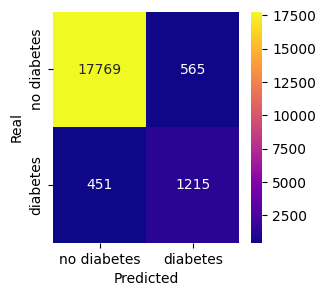

In [98]:
print(f"Accuracy: {round(accuracy_score(y_test_classifier,y_pred_pl_k_best_classifier_test),5)}")
print(f"Recall: {round(recall_score(y_test_classifier,y_pred_pl_k_best_classifier_test),5)}")
print(f"Precision: {round(precision_score(y_test_classifier,y_pred_pl_k_best_classifier_test),5)}")
print(f"F1-Score: {round(f1_score(y_test_classifier, y_pred_pl_k_best_classifier_test), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_classifier,y_pred_pl_k_best_classifier_test)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

## **`Árboles`**

### **`Threshold`**

[Text(0.4221646796695195, 0.9888888888888889, 'x[5] <= 0.582\ngini = 0.5\nsamples = 80000\nvalue = [40000.0, 40000.0]'),
 Text(0.42186571483525814, 0.9666666666666667, 'x[6] <= 0.591\ngini = 0.455\nsamples = 76840\nvalue = [40000.0, 21504.243]'),
 Text(0.4212677851667354, 0.9444444444444444, 'x[5] <= 0.336\ngini = 0.372\nsamples = 75403\nvalue = [40000.0, 13093.357]'),
 Text(0.420968820332474, 0.9222222222222223, 'gini = 0.0\nsamples = 30288\nvalue = [16558.511, 0.0]'),
 Text(0.42156675000099675, 0.9222222222222223, 'x[0] <= 0.631\ngini = 0.46\nsamples = 45115\nvalue = [23441.489, 13093.357]'),
 Text(0.16957184035190262, 0.9, 'x[4] <= 0.263\ngini = 0.267\nsamples = 28496\nvalue = [15308.75, 2891.425]'),
 Text(0.11955046994994675, 0.8777777777777778, 'x[0] <= 0.481\ngini = 0.186\nsamples = 24724\nvalue = [13372.331, 1545.215]'),
 Text(0.07169783997907246, 0.8555555555555555, 'x[6] <= 0.15\ngini = 0.111\nsamples = 18476\nvalue = [10041.823, 632.133]'),
 Text(0.0713988751448111, 0.8333333

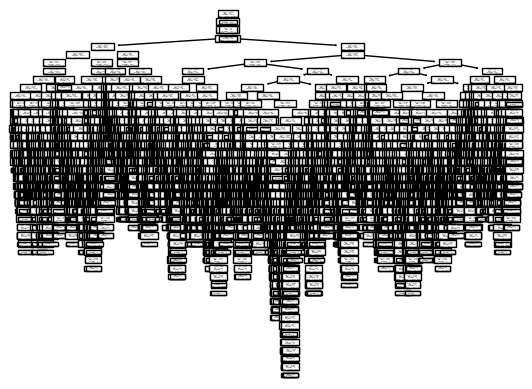

In [99]:
tree.plot_tree(clf_threshold_best_classifier)

### **`K`**

[Text(0.3400215184831754, 0.9897959183673469, 'x[4] <= 0.582\nlog_loss = 1.0\nsamples = 80000\nvalue = [40000.0, 40000.0]'),
 Text(0.3396569785368596, 0.9693877551020408, 'x[5] <= 0.591\nlog_loss = 0.934\nsamples = 76840\nvalue = [40000.0, 21504.243]'),
 Text(0.338927898644228, 0.9489795918367347, 'x[4] <= 0.336\nlog_loss = 0.806\nsamples = 75403\nvalue = [40000.0, 13093.357]'),
 Text(0.3385633586979122, 0.9285714285714286, 'log_loss = 0.0\nsamples = 30288\nvalue = [16558.511, 0.0]'),
 Text(0.3392924385905438, 0.9285714285714286, 'x[5] <= 0.15\nlog_loss = 0.941\nsamples = 45115\nvalue = [23441.489, 13093.357]'),
 Text(0.338927898644228, 0.9081632653061225, 'log_loss = 0.0\nsamples = 13196\nvalue = [7214.28, 0.0]'),
 Text(0.3396569785368596, 0.9081632653061225, 'x[0] <= 0.531\nlog_loss = 0.992\nsamples = 31919\nvalue = [16227.209, 13093.357]'),
 Text(0.05994418795578618, 0.8877551020408163, 'x[0] <= 0.318\nlog_loss = 0.599\nsamples = 15950\nvalue = [8583.222, 1463.272]'),
 Text(0.012887

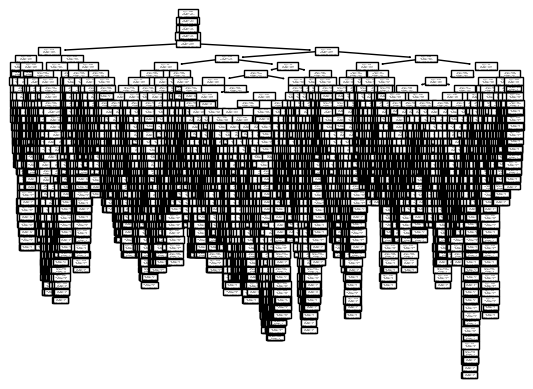

In [100]:
tree.plot_tree(clf_k_best_classifier)

# **`Random Forest Classifier`**

## **`Entrenamiento`**

In [104]:
#Definimos las features
#features = mapData sin la columna 'diabetes'
features_forest_classifier = mapData.drop('diabetes', axis=1).columns
features_forest_classifier = features_forest_classifier.drop('gender_Other')

X_forest_classifier = mapData[features_forest_classifier]    # Features
y_forest_classifier = mapData['diabetes']  # Target variable

X_train_forest_classifier, X_test_forest_classifier, y_train_forest_classifier, y_test_forest_classifier = train_test_split(X_forest_classifier, y_forest_classifier, test_size=0.2, random_state=101) # 80% training and 20% test

### **`Log Loss`**

In [112]:
clf_log_loss_forest_classifier = RandomForestClassifier(criterion='log_loss', max_depth=175, min_samples_split=2, class_weight="balanced", n_jobs=-1)
clf_log_loss_forest_classifier = clf_log_loss_forest_classifier.fit(X_train_forest_classifier,y_train_forest_classifier)

y_pred_log_loss_forest_train_classifier = clf_log_loss_forest_classifier.predict(X_train_forest_classifier)
y_pred_log_loss_forest_test_classifier = clf_log_loss_forest_classifier.predict(X_test_forest_classifier)

### **`Train Log Loss`**



Accuracy: 0.99902
Recall: 0.99985
Precision: 0.98886
F1-Score: 0.99432


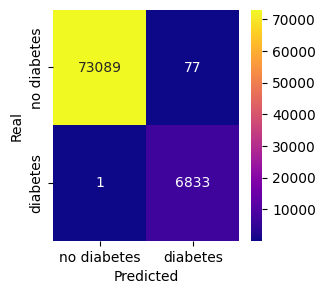

In [113]:
print(f"Accuracy: {round(accuracy_score(y_train_forest_classifier,y_pred_log_loss_forest_train_classifier),5)}")
print(f"Recall: {round(recall_score(y_train_forest_classifier,y_pred_log_loss_forest_train_classifier),5)}")
print(f"Precision: {round(precision_score(y_train_forest_classifier,y_pred_log_loss_forest_train_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_train_forest_classifier, y_pred_log_loss_forest_train_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_train_forest_classifier,y_pred_log_loss_forest_train_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

### **`Test Log Loss`**

Accuracy: 0.969
Recall: 0.67227
Precision: 0.93802
F1-Score: 0.78322


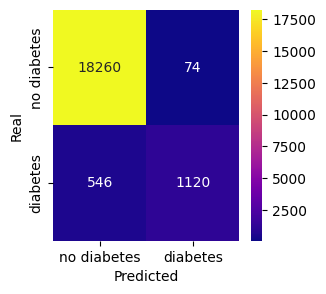

In [116]:
print(f"Accuracy: {round(accuracy_score(y_test_forest_classifier,y_pred_log_loss_forest_test_classifier),5)}")
print(f"Recall: {round(recall_score(y_test_forest_classifier,y_pred_log_loss_forest_test_classifier),5)}")
print(f"Precision: {round(precision_score(y_test_forest_classifier,y_pred_log_loss_forest_test_classifier),5)}")
print(f"F1-Score: {round(f1_score(y_test_forest_classifier, y_pred_log_loss_forest_test_classifier), 5)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_forest_classifier,y_pred_log_loss_forest_test_classifier)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

## **`Forest`**

In [118]:
print(f"Número de árboles: {len(clf_log_loss_forest_classifier.estimators_)}")

Número de árboles: 100


In [119]:
# Desactivar las advertencias
warnings.filterwarnings('ignore', message="X has feature names, but DecisionTreeClassifier was fitted without feature names")

idx0 = 5
new_x = X_test_forest_classifier[idx0:idx0+1]  # Pasamos una matriz de tamaño 1 x num_features
print(f"Etiqueta real: {y_test_forest_classifier[idx0]}, Predicción: {y_pred_log_loss_forest_test_classifier[idx0]}")

predicciones = []
for dt in clf_log_loss_forest_classifier.estimators_:
    predicted_label = int(dt.predict(new_x)[0])
    predicciones.append(predicted_label)

print(f"Las primeras 10 predicciones: {predicciones[:10]}")

# ---- Contamos cuántos votos tuvo cada etiqueta por parte del bosque ----

zeros = np.where(np.array(predicciones)==0)[0]
ones = np.where(np.array(predicciones)==1)[0]

print(f"{zeros.shape[0]} árboles que predijeron la etiqueta 0:\n{zeros}\n")
print(f"{ones.shape[0]} Árboles que predijeron la etiqueta 1:\n{ones}\n")


Etiqueta real: 0, Predicción: 0
Las primeras 10 predicciones: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
99 árboles que predijeron la etiqueta 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 95 96
 97 98 99]

1 Árboles que predijeron la etiqueta 1:
[93]



In [120]:
dt = clf_log_loss_forest_classifier.estimators_[5]

print(f"Profundidad del árbol: {dt.get_depth()}")
print(f"Número de hojas del árbol: {dt.get_n_leaves()}")

text_representation = tree.export_text(decision_tree=dt, feature_names=features_forest_classifier.tolist())

Profundidad del árbol: 34
Número de hojas del árbol: 3327


In [121]:
print(text_representation)

|--- blood_glucose_level <= 210.00
|   |--- HbA1c_level <= 6.70
|   |   |--- HbA1c_level <= 5.35
|   |   |   |--- class: 0.0
|   |   |--- HbA1c_level >  5.35
|   |   |   |--- hypertension <= 0.50
|   |   |   |   |--- heart_disease <= 0.50
|   |   |   |   |   |--- gender_Male <= 0.50
|   |   |   |   |   |   |--- age <= 43.50
|   |   |   |   |   |   |   |--- smoking_history <= 0.50
|   |   |   |   |   |   |   |   |--- blood_glucose_level <= 113.00
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- blood_glucose_level >  113.00
|   |   |   |   |   |   |   |   |   |--- age <= 25.50
|   |   |   |   |   |   |   |   |   |   |--- blood_glucose_level <= 159.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |   |--- blood_glucose_level >  159.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- age >  25.50
|   |   |   |   |   |   |   |   |   